<a href="https://colab.research.google.com/github/hugobbi/generating-rare-concepts/blob/main/dl_cv_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

## Imports

In [20]:
import torch
from torchvision import transforms
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from dataclasses import dataclass
import os
import numpy as np
import torch.nn.functional as F

## Utils

In [95]:
def get_inputs(prompt, batch_size=1, num_inference_steps=20):
  generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
  prompts = [prompt for _ in range(batch_size)]

  return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_to_tensor(image):
    image_tensor = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # normalize between -1 and 1
    ])(image)

    return image_tensor.unsqueeze(0).to("cuda", dtype=torch.float16) # unsqueeze(0) adds new dimension to tensor at index 0

def map_to_zero_one(tensor):
    tensor = (tensor.clamp(-1, 1) + 1) / 2.0 # map tensor from (-1, 1) to (0, 1)
    return tensor

@dataclass
class Clip:
    model: CLIPModel
    processor: CLIPProcessor

def load_images_from_dir(imgs_path) -> list[Image.Image]:
    images = []
    for img in os.listdir(imgs_path):
        if img.endswith(('.jpeg', '.jpg', '.png')):
            images.append(Image.open(os.path.join(imgs_path, img)))
    return images

def print_pipe_info(pipe):
    print(pipe.__dict__)

## Getting reference images from google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

IMGS_DIR = "/content/drive/MyDrive/ufrgs-cloud/etapa8/deep_learning/images/"

Mounted at /content/drive


## Importing Stable Diffusion 2.1 from HuggingFace and CLIP vision model

In [104]:
# Paper:
# SeedSelect employs Stable Diffusion v2.1 with a guidance scale of 7.5 and 7 denoising steps
# using EulerDiscreteScheduler (Karras et al. 2022)
model_id = "stabilityai/stable-diffusion-2-1-base" # use "stabilityai/stable-diffusion-2-1-base" (512x512) if not enough ram other is (768x768)

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    scheduler=EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
).to("cuda")

# Parameters for image generation
NUM_INFERENCE_STEPS = 20 # 7 (paper)
GUIDANCE_SCALE = 7.5

# CLIP vision model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip = Clip(model=clip_model, processor=clip_processor)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [64]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Using SD model

  0%|          | 0/20 [00:00<?, ?it/s]

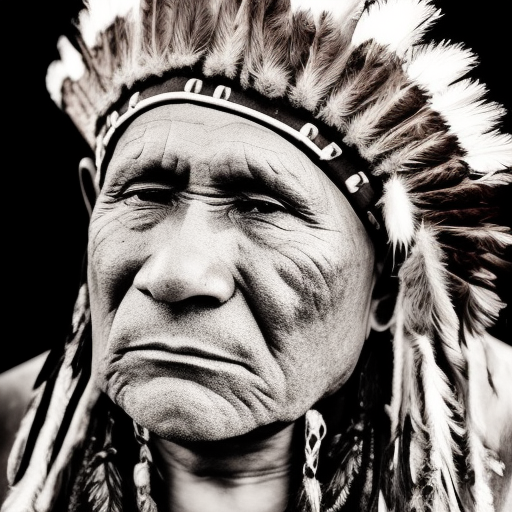

In [65]:
generator = torch.Generator("cuda").manual_seed(0)
prompt = "portrait photo of an old warrior chief"
image = pipe(prompt, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]

image

  0%|          | 0/20 [00:00<?, ?it/s]

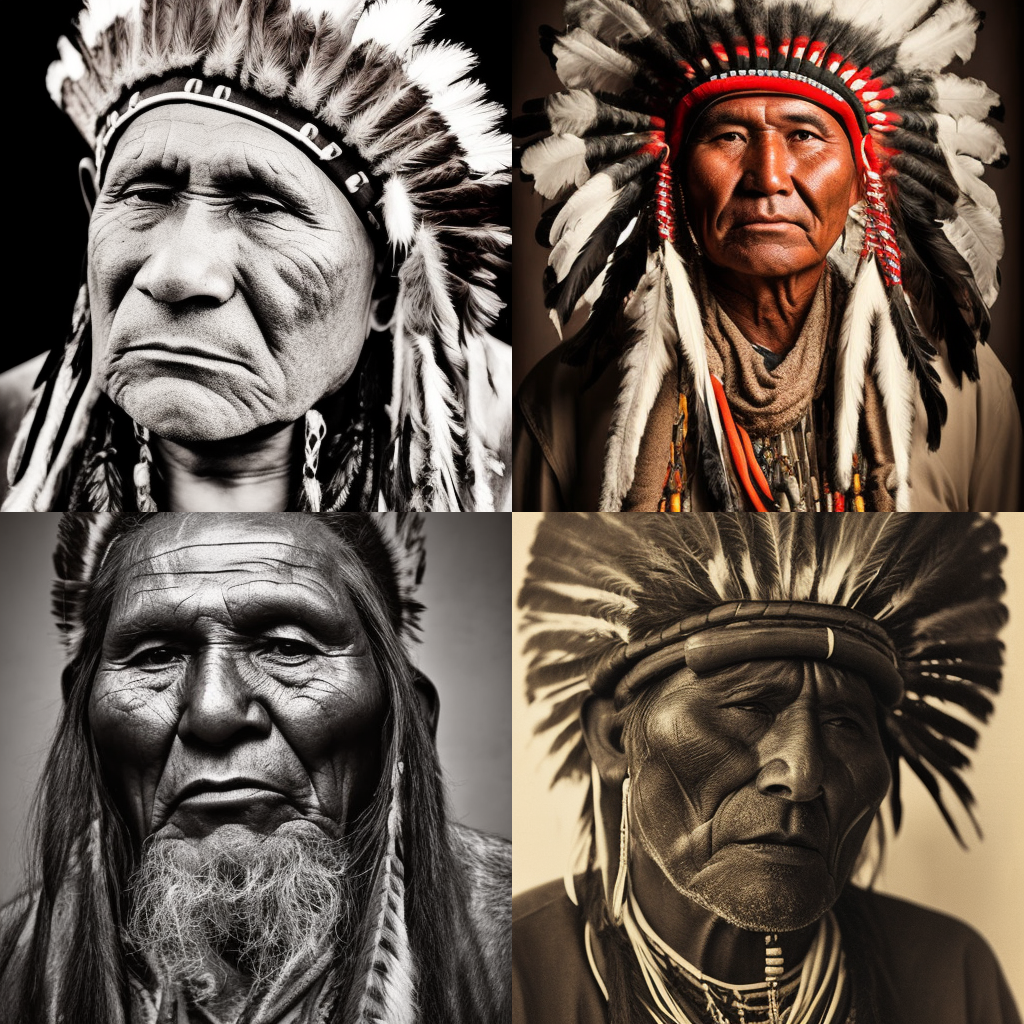

In [66]:
images = pipe(**get_inputs(prompt=prompt, batch_size=4)).images
image_grid(images)

## VAE

In [7]:
# VAE

def encode_image_vae(pipe, image):
    vae = pipe.vae
    image_tensor = image_to_tensor(image)
    with torch.no_grad():
        image_latent = vae.encode(image_tensor).latent_dist.sample().detach() # samples from latent distribution
        image_latent *= 0.18215

    return image_latent

def decode_vae(pipe, image_latent):
    vae = pipe.vae
    with torch.no_grad():
        image_latent /= 0.18215
        image = vae.decode(image_latent).sample

    image = map_to_zero_one(image)

    return image

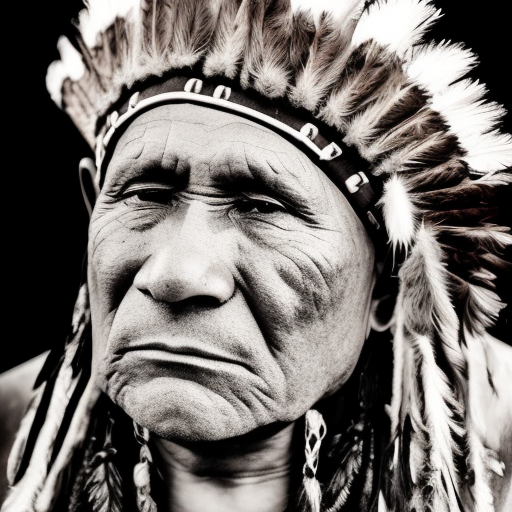

In [67]:
img_latent = encode_image_vae(pipe, image)
img = decode_vae(pipe, img_latent)
img_pil = transforms.ToPILImage()(img.squeeze())
img_pil

## CLIP Vision

In [8]:
# CLIP

def encode_image_clip(clip_model, clip_processor, image):
    inputs = clip_processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=inputs["pixel_values"])

    return image_embeddings

In [68]:
image_embeddings = encode_image_clip(clip_model, clip_processor, image)
image_embeddings.shape

torch.Size([1, 768])

## Using random gaussian as initial latent

  0%|          | 0/20 [00:00<?, ?it/s]

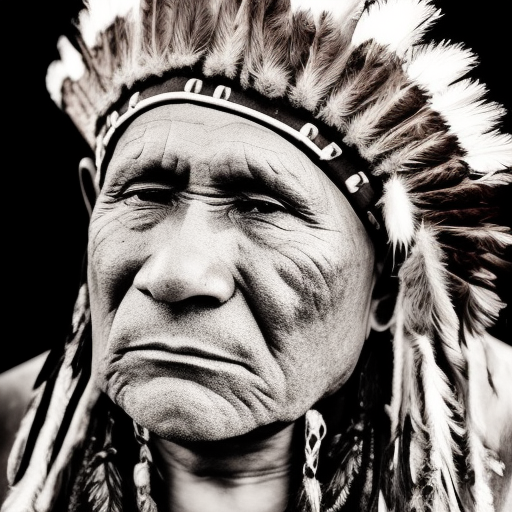

In [69]:
# Generating and using custom gaussian noise tensor

# Matching the UNet input size
batch_size = 1
channels = pipe.unet.config.in_channels
height = 512 // 8  # latent space size (image size divided by 8)
width = 512 // 8

generator = torch.Generator("cuda").manual_seed(0)
custom_latents = torch.randn((batch_size, channels, height, width), device="cuda", dtype=torch.float16, generator=generator)
output_custom_latents = pipe(prompt, latents=custom_latents, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator)

image_custom_latents = output_custom_latents.images[0]
image_custom_latents

## Computing loss

  0%|          | 0/20 [00:00<?, ?it/s]

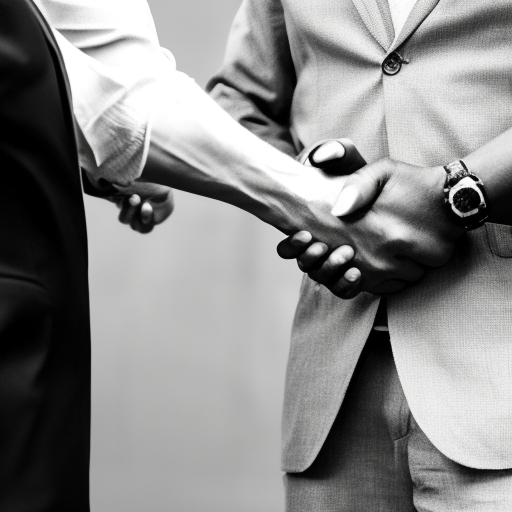

In [70]:
prompt = "two men shaking hands"
generator = torch.Generator("cuda").manual_seed(0)
test_img = pipe(prompt, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]
test_img

## Semantic loss

In [10]:
def compute_semantic_loss(clip: Clip, image: Image.Image, *reference_images: Image.Image) -> float:
    vg = encode_image_clip(clip.model, clip.processor, image)

    u_v_tensors = []
    for reference_image in reference_images:
        u_i = encode_image_clip(clip.model, clip.processor, reference_image)
        u_v_tensors.append(u_i)

    u_v_stack = torch.stack(u_v_tensors)
    u_v = u_v_stack.mean(dim=0)

    loss = torch.dist(vg, u_v, p=2) # p=2 for Euclidian distance

    return loss # maybe convert to float (float or .item())

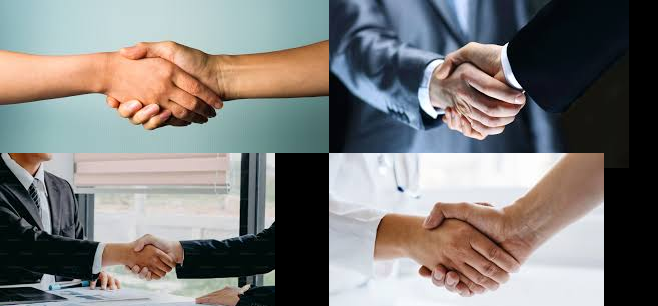

In [47]:
imgs_type = "hs"
reference_images = load_images_from_dir(os.path.join(IMGS_DIR, imgs_type))
image_grid(reference_images)

In [71]:
semantic_loss = compute_semantic_loss(clip, test_img, *reference_images)
semantic_loss

11.07470989227295

## Visual loss

In [41]:
def compute_visual_loss(pipe: StableDiffusionPipeline, image: Image.Image, *reference_images: Image.Image) -> float:
    image_latent = encode_image_vae(pipe, image)
    loss, k = 0, 0
    for reference_image in reference_images:
        reference_image_latent = encode_image_vae(pipe, reference_image)
        loss += F.mse_loss(image_latent, reference_image_latent, reduction='mean')
        k += 1
    return loss / k

In [72]:
visual_loss = compute_visual_loss(pipe, test_img, *reference_images)
visual_loss

tensor(2.0078, device='cuda:0', dtype=torch.float16)

## Total loss

In [98]:
def compute_total_loss(
        pipe: StableDiffusionPipeline,
        clip: Clip,
        image: Image.Image,
        *reference_images: Image.Image,
        lambda_factor: float=0.9) -> float:
    semantic_loss = compute_semantic_loss(clip, image, *reference_images)
    visual_loss = compute_visual_loss(pipe, image, *reference_images)

    return lambda_factor * semantic_loss + (1 - lambda_factor) * visual_loss

In [99]:
compute_total_loss(pipe, clip, test_img, *reference_images)

tensor(10.1719, device='cuda:0', dtype=torch.float16)

## Optimize initial latent

In [138]:
def freeze_params(module):
    for param in module.parameters():
        param.requires_grad = False
    for name, submodule in module.named_children():
        if isinstance(submodule, torch.nn.Module):
            freeze_params(submodule)

def check_if_trainable_params(module, tp):
    for param_name, param in module.named_parameters():
        if param.requires_grad:
            tp = True
            print(f"Parameter {param_name} is trainable!!!")
    for name, submodule in module.named_children():
        if isinstance(submodule, torch.nn.Module):
            check_if_trainable_params(submodule, tp)

def check_if_trainable_params_pipe(pipe):
    tp = False
    for submodule_name in pipe.components:
        submodule = pipe.components[submodule_name]
        if isinstance(submodule, torch.nn.Module):
            print(f"Checking in {submodule.__class__.__name__}...")
            check_if_trainable_params(submodule, tp)
    if not tp:
        print("No trainable parameters found :)")
    return tp

def freeze_params_pipe(pipe):
    for submodule_name in pipe.components:
        submodule = pipe.components[submodule_name]
        if isinstance(submodule, torch.nn.Module):
            freeze_params(submodule)

def assert_no_trainable_params(pipe):
    assert not check_if_trainable_params_pipe(pipe), "Stable Diffusion Pipeline has trainable parameters."

def optimize_latent(
        pipe: StableDiffusionPipeline,
        clip: Clip,
        prompt: str,
        *reference_images: Image.Image,
        num_inference_steps: int=20,
        guidance_scale: float=7.5,
        lambda_factor: float=0.9,

):
    return

Frezzing parameters and asserting all parameters in SD pipe are not trainanle

In [141]:
freeze_params_pipe(pipe)
assert_no_trainable_params(pipe)

Checking in AutoencoderKL...
Checking in CLIPTextModel...
Checking in UNet2DConditionModel...
No trainable parameters found :)


## TODO

- generate images [x]
- access vae [x]
- access initial distribution [x]
- access clip encoder [x]
- compute semantic loss [x]
- compute visual loss [x]
- optimize new latent []